OPIM 5509: Introduction to Deep Learning;
*   Homework #1: CA Housing DNN
*   Author: Qi Zhou 


#### Columns:
1. longitude: A measure of how far west a house is; a higher value is farther west
2. latitude: A measure of how far north a house is; a higher value is farther north
3. housingMedianAge: Median age of a house within a block; a lower number is a newer building
4. totalRooms: Total number of rooms within a block
5. totalBedrooms: Total number of bedrooms within a block
6. population: Total number of people residing within a block
7. households: Total number of households, a group of people residing within a home unit, for a block
8. medianIncome: Median income for households within a block of houses (measured in tens of thousands of US Dollars)
9. medianHouseValue: Median house value for households within a block (measured in US Dollars)
10. oceanProximity: Location of the house w.r.t ocean/sea

In [109]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

#### Load Data

In [0]:
# https://drive.google.com/file/d/11_CrABFOd7SgTJuLZSYLs3szh5xN_S-W/view?usp=sharing
url = "https://drive.google.com/uc?export=download&id=11_CrABFOd7SgTJuLZSYLs3szh5xN_S-W" 
data = pd.read_csv(url)

In [145]:
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


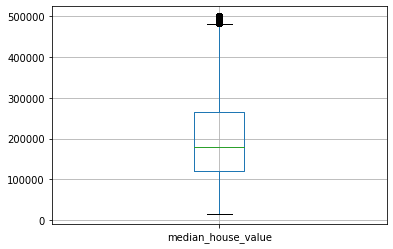

In [146]:
import matplotlib.pyplot as plt
# Plot the median house value
data.boxplot(column='median_house_value')

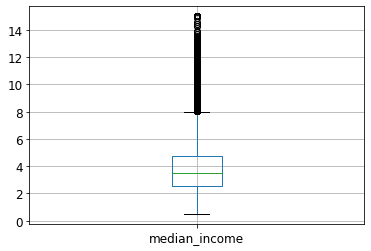

In [150]:
# Plot the median income
data.boxplot(column='median_income', fontsize=12)

In [148]:
# Check missing value and shape of the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [116]:
# Drop missing values
data = data.dropna(how="any")
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20433 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20433 non-null float64
latitude              20433 non-null float64
housing_median_age    20433 non-null float64
total_rooms           20433 non-null float64
total_bedrooms        20433 non-null float64
population            20433 non-null float64
households            20433 non-null float64
median_income         20433 non-null float64
median_house_value    20433 non-null float64
ocean_proximity       20433 non-null object
dtypes: float64(9), object(1)
memory usage: 1.7+ MB


In [117]:
data.groupby("ocean_proximity")["median_house_value"].count()

ocean_proximity
<1H OCEAN     9034
INLAND        6496
ISLAND           5
NEAR BAY      2270
NEAR OCEAN    2628
Name: median_house_value, dtype: int64

#### Feature Engineering

In [118]:
# Create dummy variables
data = pd.get_dummies(data, columns=["ocean_proximity"], drop_first=True)
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,0,0,1,0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,0,0,1,0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,0,0,1,0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,0,0,1,0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,0,0,1,0


In [119]:
# Perform min/max normalization on the numeric columns
X = data.iloc[:,2:8]
scaler = MinMaxScaler(feature_range=(0, 1))
rescaledX = scaler.fit_transform(X)
data.iloc[:,2:8] = rescaledX
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-122.23,37.88,0.784314,0.022331,0.019863,0.008941,0.020556,0.539668,452600.0,0,0,1,0
1,-122.22,37.86,0.392157,0.180503,0.171477,0.067210,0.186976,0.538027,358500.0,0,0,1,0
2,-122.24,37.85,1.000000,0.037260,0.029330,0.013818,0.028943,0.466028,352100.0,0,0,1,0
3,-122.25,37.85,1.000000,0.032352,0.036313,0.015555,0.035849,0.354699,341300.0,0,0,1,0
4,-122.25,37.85,1.000000,0.041330,0.043296,0.015752,0.042427,0.230776,342200.0,0,0,1,0


In [120]:
# Create a categorical variable
# Binning
data.sort_values('median_house_value', inplace=True)
group_names = ['Cheaper House','Average House','Expensive House']
group_bins = pd.qcut(data['median_house_value'], 3, labels=group_names)
pd.value_counts(group_bins)

Average House      6812
Cheaper House      6812
Expensive House    6809
Name: median_house_value, dtype: int64

In [121]:
# Add a new column called "Percentiles"
data['Percentiles'] = group_bins
data.sort_index(inplace=True)
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN,Percentiles
0,-122.23,37.88,0.784314,0.022331,0.019863,0.008941,0.020556,0.539668,452600.0,0,0,1,0,Expensive House
1,-122.22,37.86,0.392157,0.180503,0.171477,0.067210,0.186976,0.538027,358500.0,0,0,1,0,Expensive House
2,-122.24,37.85,1.000000,0.037260,0.029330,0.013818,0.028943,0.466028,352100.0,0,0,1,0,Expensive House
3,-122.25,37.85,1.000000,0.032352,0.036313,0.015555,0.035849,0.354699,341300.0,0,0,1,0,Expensive House
4,-122.25,37.85,1.000000,0.041330,0.043296,0.015752,0.042427,0.230776,342200.0,0,0,1,0,Expensive House


### Regression Problem

#### Model Fitting

In [122]:
# Shuffle the data randomly (the rows)
model_data = shuffle(data.iloc[:,2:], random_state=123).reset_index(drop=True)
model_data.head()

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN,Percentiles
0,0.431373,0.061371,0.101179,0.035651,0.097846,0.181997,101800.0,0,0,0,1,Cheaper House
1,0.450980,0.072893,0.081626,0.035903,0.079921,0.194363,213000.0,1,0,0,0,Average House
2,0.745098,0.059973,0.094041,0.057289,0.099326,0.083137,58800.0,1,0,0,0,Cheaper House
3,0.196078,0.031207,0.036468,0.016200,0.031080,0.179453,111300.0,0,0,0,0,Cheaper House
4,0.392157,0.044153,0.045624,0.027467,0.048841,0.298444,174100.0,0,0,0,1,Average House


In [123]:
# Do an 8:2 for training/validation split.
X = model_data.drop(["median_house_value","Percentiles"], axis=1)
y = model_data["median_house_value"]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state= 525)
print(X_train.shape)
print(X_test.shape)

(16346, 10)
(4087, 10)


In [124]:
# Fit neural networks
# Model 1
def create_model1():
    model1 = Sequential()
    model1.add(Dense(32, input_dim=10, activation='relu'))
    model1.add(Dropout(0.2))
    model1.add(Dense(32, activation='relu'))
    model1.add(Dropout(0.2))
    model1.add(Dense(1))
    model1.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model1
model1 = KerasRegressor(build_fn=create_model1)

batch_size = [10, 20]
epochs = [25, 50]
param_grid = dict(batch_size=batch_size, epochs=epochs)
M1_best_model = GridSearchCV(estimator=model1, cv=3, param_grid=param_grid, n_jobs=-1)
M1_model = M1_best_model.fit(X_train, y_train)
print("Best: %f using %s" % (M1_best_model.best_score_, M1_best_model.best_params_))

Epoch 1/50
16346/16346 [==============================] - 3s 171us/step - loss: 55851448999.5762 - mean_absolute_error: 206060.1453
Epoch 2/50
16346/16346 [==============================] - 2s 129us/step - loss: 48435929483.7930 - mean_absolute_error: 186799.3244
Epoch 3/50
16346/16346 [==============================] - 2s 129us/step - loss: 29250308055.8130 - mean_absolute_error: 131125.0998
Epoch 4/50
16346/16346 [==============================] - 2s 130us/step - loss: 14989572075.7734 - mean_absolute_error: 93442.4006
Epoch 5/50
16346/16346 [==============================] - 2s 126us/step - loss: 12676528075.0334 - mean_absolute_error: 88115.3141
Epoch 6/50
16346/16346 [==============================] - 2s 125us/step - loss: 11628888568.8271 - mean_absolute_error: 83827.6862
Epoch 7/50
16346/16346 [==============================] - 2s 131us/step - loss: 10712191776.2936 - mean_absolute_error: 80116.1104
Epoch 8/50
16346/16346 [==============================] - 2s 134us/step - loss: 

In [125]:
# Model 2
def create_model2():
    model2 = Sequential()
    model2.add(Dense(64, input_dim=10, activation='relu'))
    model2.add(Dropout(0.5))
    model2.add(Dense(64, activation='relu'))
    model2.add(Dropout(0.5))
    model2.add(Dense(64, activation='relu'))
    model2.add(Dropout(0.5))
    model2.add(Dense(1))
    model2.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model2
model2 = KerasRegressor(build_fn=create_model2)

batch_size = [10, 20]
epochs = [25, 50]
param_grid = dict(batch_size=batch_size, epochs=epochs)
M2_best_model = GridSearchCV(estimator=model2, cv=3, param_grid=param_grid, n_jobs=-1)
M2_model = M2_best_model.fit(X_train, y_train)
print("Best: %f using %s" % (M2_best_model.best_score_, M2_best_model.best_params_))

Epoch 1/50
16346/16346 [==============================] - 3s 186us/step - loss: 31974941004.1140 - mean_absolute_error: 140111.9364
Epoch 2/50
16346/16346 [==============================] - 2s 141us/step - loss: 11867463802.5499 - mean_absolute_error: 82375.1204
Epoch 3/50
16346/16346 [==============================] - 2s 143us/step - loss: 10081325234.9385 - mean_absolute_error: 74571.7441
Epoch 4/50
16346/16346 [==============================] - 2s 140us/step - loss: 9238813422.1383 - mean_absolute_error: 70907.6517
Epoch 5/50
16346/16346 [==============================] - 2s 138us/step - loss: 8769539285.1036 - mean_absolute_error: 68668.4966
Epoch 6/50
16346/16346 [==============================] - 2s 137us/step - loss: 8586229173.0762 - mean_absolute_error: 67509.1122
Epoch 7/50
16346/16346 [==============================] - 2s 142us/step - loss: 8256550519.5742 - mean_absolute_error: 66026.0810
Epoch 8/50
16346/16346 [==============================] - 2s 140us/step - loss: 810850

In [126]:
# Model 3
def create_model3():
    model3 = Sequential()
    model3.add(Dense(16, input_dim=10, activation='relu'))
    model3.add(Dropout(0.3))
    model3.add(Dense(16, activation='relu'))
    model3.add(Dropout(0.3))
    model3.add(Dense(16, activation='relu'))
    model3.add(Dropout(0.3))
    model3.add(Dense(16, activation='relu'))
    model3.add(Dropout(0.3))
    model3.add(Dense(1))
    model3.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model3
model3 = KerasRegressor(build_fn=create_model3)

batch_size = [10, 20]
epochs = [25, 50]
param_grid = dict(batch_size=batch_size, epochs=epochs)
M3_best_model = GridSearchCV(estimator=model3, cv=3, param_grid=param_grid, n_jobs=-1)
M3_model = M3_best_model.fit(X_train, y_train)
print("Best: %f using %s" % (M3_best_model.best_score_, M3_best_model.best_params_))

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Epoch 1/50
16346/16346 [==============================] - 3s 197us/step - loss: 42185579322.7300 - mean_absolute_error: 168712.0303
Epoch 2/50
16346/16346 [==============================] - 2s 141us/step - loss: 16522505824.1840 - mean_absolute_error: 97685.8862
Epoch 3/50
16346/16346 [==============================] - 2s 139us/step - loss: 14468181762.4588 - mean_absolute_error: 89902.8073
Epoch 4/50
16346/16346 [==============================] - 2s 139us/step - loss: 13485493733.4619 - mean_absolute_error: 86008.5900
Epoch 5/50
16346/16346 [==============================] - 2s 139us/step - loss: 12816284930.8190 - mean_absolute_error: 83170.8590
Epoch 6/50
16346/16346 [==============================] - 2s 142us/step - loss: 12211299911.3921 - mean_absolute_error: 80954.3736
Epoch 7/50
16346/16346 [==============================] - 2s 147us/step - loss: 11922753133.7467 - mean_absolute_error: 79765.7957
Epoch 8/50
16346/16346 [==============================] - 2s 145us/step - loss: 11

#### Model Validation

In [127]:
# MAE and RSME of the training data
# Model 1
M1_train_y = M1_model.predict(X_train)
M1_train_mae = mean_absolute_error(y_train, M1_train_y)
M1_train_rsme = np.sqrt(mean_squared_error (y_train, M1_train_y))
print("M1 Train MAE Score = ", round(M1_train_mae,2))
print("M1 Train RMSE Score = ", round(M1_train_rsme,2))

# Model 2
M2_train_y = M2_model.predict(X_train)
M2_train_mae = mean_absolute_error(y_train, M2_train_y)
M2_train_rsme = np.sqrt(mean_squared_error (y_train, M2_train_y))
print("M2 Train MAE Score = ", round(M2_train_mae,2))
print("M2 Train RMSE Score = ", round(M2_train_rsme,2))

# Model 3
M3_train_y = M3_model.predict(X_train)
M3_train_mae = mean_absolute_error(y_train, M3_train_y)
M3_train_rsme = np.sqrt(mean_squared_error (y_train, M3_train_y))
print("M3 Train MAE Score = ", round(M3_train_mae,2))
print("M3 Train RMSE Score = ", round(M3_train_rsme,2))

M1 Train MAE Score =  52097.57
M1 Train RMSE Score =  72574.15
M2 Train MAE Score =  49140.52
M2 Train RMSE Score =  70808.63
M3 Train MAE Score =  50204.04
M3 Train RMSE Score =  72179.33


In [128]:
# MAE and RSME of the validation data 
# Model 1
M1_test_y = M1_model.predict(X_test)
M1_test_mae = mean_absolute_error(y_test, M1_test_y)
M1_test_rsme = np.sqrt(mean_squared_error (y_test, M1_test_y))
print("M1 Test MAE Score = ", round(M1_test_mae,2))
print("M1 Test RMSE Score = ", round(M1_test_rsme,2))

# Model 2
M2_test_y = M2_model.predict(X_test)
M2_test_mae = mean_absolute_error(y_test, M2_test_y)
M2_test_rsme = np.sqrt(mean_squared_error (y_test, M2_test_y))
print("M2 Test MAE Score = ", round(M2_test_mae,2))
print("M2 Test RMSE Score = ", round(M2_test_rsme,2))

# Model 3 
M3_test_y = M3_model.predict(X_test)
M3_test_mae = mean_absolute_error(y_test, M3_test_y)
M3_test_rsme = np.sqrt(mean_squared_error (y_test, M3_test_y))
print("M3 Test MAE Score = ", round(M3_test_mae,2))
print("M3 Test RMSE Score = ", round(M3_test_rsme,2))

M1 Test MAE Score =  51052.21
M1 Test RMSE Score =  70223.92
M2 Test MAE Score =  48016.7
M2 Test RMSE Score =  68283.8
M3 Test MAE Score =  48767.14
M3 Test RMSE Score =  69594.96


In [129]:
# MAE and RMSE Table 
data = {'Model 1':[M1_train_mae, M1_train_rsme, M1_test_mae, M1_test_rsme], 'Model 2':[M2_train_mae, M2_train_rsme, M2_test_mae, M2_test_rsme],'Model 3':[M3_train_mae, M3_train_rsme, M3_test_mae, M3_test_rsme]} 
Model_Comparison = pd.DataFrame(data, index=["Train MAE","Train RSME", "Test MAE", "Test RSME"]) 
Model_Comparison.to_csv('/content/drive/My Drive/Deep Learning/Week 1/mae_rsme_table.csv')
Model_Comparison

,Model 1,Model 2,Model 3
Train MAE,52097.574076,49140.515261,50204.037882
Train RSME,72574.148403,70808.626926,72179.334363
Test MAE,51052.212146,48016.703218,48767.138993
Test RSME,70223.920048,68283.803209,69594.959121


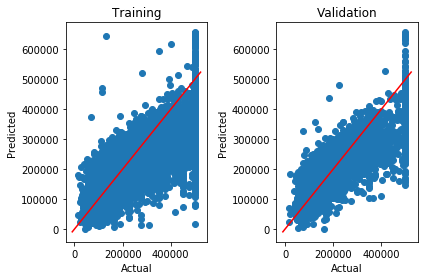

In [130]:
# Scatterplot of the training and validation data 
import matplotlib.pyplot as plt
%matplotlib inline

# Model 1
fig, axes = plt.subplots(1,2)

# Training Results
axes[0].scatter(x=y_train, y=M1_model.predict(X_train)) 
axes[0].set_xlabel("Actual", fontsize=10)
axes[0].set_ylabel("Predicted",  fontsize=10)
axes[0].set_title("Training")
x = np.linspace(*axes[0].get_xlim())
axes[0].plot(x, x, color='red')

# Validation Results
axes[1].scatter(x=y_test, y=M1_model.predict(X_test))
axes[1].set_xlabel("Actual", fontsize=10)
axes[1].set_ylabel("Predicted",  fontsize=10)
axes[1].set_title("Validation")
x = np.linspace(*axes[1].get_xlim())
axes[1].plot(x, x, color='red')

fig.tight_layout()
plt.savefig('/content/drive/My Drive/Deep Learning/Week 1/M1_Results_Plot.png')
plt.show()

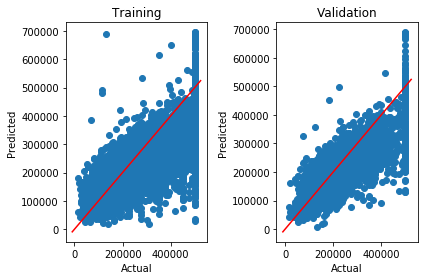

In [131]:
# Model 2
fig, axes = plt.subplots(1,2) 

# Training Results
axes[0].scatter(x=y_train, y=M2_model.predict(X_train)) 
axes[0].set_xlabel("Actual", fontsize=10)
axes[0].set_ylabel("Predicted",  fontsize=10)
axes[0].set_title("Training")
x = np.linspace(*axes[0].get_xlim())
axes[0].plot(x, x, color='red')

# Validation Results
axes[1].scatter(x=y_test, y=M2_model.predict(X_test)) 
axes[1].set_xlabel("Actual", fontsize=10)
axes[1].set_ylabel("Predicted",  fontsize=10)
axes[1].set_title("Validation")
x = np.linspace(*axes[1].get_xlim())
axes[1].plot(x, x, color='red')

fig.tight_layout()
plt.savefig('/content/drive/My Drive/Deep Learning/Week 1/M2_Results_Plot.png')
plt.show()

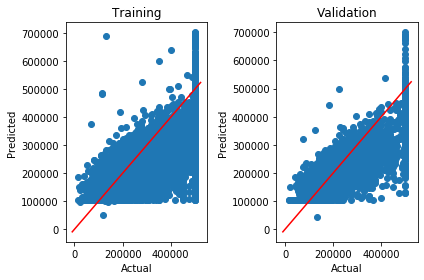

In [132]:
# Model 3
fig, axes = plt.subplots(1,2)

# Training Results
axes[0].scatter(x=y_train, y=M3_model.predict(X_train)) 
axes[0].set_xlabel("Actual", fontsize=10)
axes[0].set_ylabel("Predicted",  fontsize=10)
axes[0].set_title("Training")
x = np.linspace(*axes[0].get_xlim())
axes[0].plot(x, x, color='red')

# Validation Results
axes[1].scatter(x=y_test, y=M3_model.predict(X_test)) 
axes[1].set_xlabel("Actual", fontsize=10)
axes[1].set_ylabel("Predicted",  fontsize=10)
axes[1].set_title("Validation")
x = np.linspace(*axes[1].get_xlim())
axes[1].plot(x, x, color='red')

fig.tight_layout()
plt.savefig('/content/drive/My Drive/Deep Learning/Week 1/M3_Results_Plot.png')
plt.show()

### Binary Classification Problem

#### Data Preparation

In [0]:
# Create a binary target variable using median_house_value, above average and below average value
above_avg = model_data[model_data['median_house_value']>= model_data['median_house_value'].mean()]
below_avg = model_data[model_data['median_house_value']< model_data['median_house_value'].mean()]

In [75]:
above_avg['above_avg_price'] = 1
below_avg['above_avg_price'] = 0
binary_model_data = pd.concat([above_avg,below_avg], axis=0)
binary_model_data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN,Percentiles,above_avg_price
1,0.450980,0.072893,0.081626,0.035903,0.079921,0.194363,213000.0,1,0,0,0,Average House,1
7,0.803922,0.083677,0.110490,0.062250,0.110673,0.210466,291500.0,0,0,0,0,Expensive House,1
9,0.568627,0.070197,0.091868,0.044228,0.082388,0.317258,319400.0,0,0,0,1,Expensive House,1
13,1.000000,0.048349,0.071384,0.023207,0.071041,0.272169,500001.0,0,0,1,0,Expensive House,1
15,1.000000,0.056107,0.063315,0.022086,0.066930,0.368333,500000.0,0,0,0,1,Expensive House,1


#### Model Fitting

In [0]:
binary_model_data = binary_model_data.drop(['median_house_value'],axis=1)

In [77]:
# Shuffle the data randomly (the rows)
binary_model_data = shuffle(binary_model_data, random_state=123).reset_index(drop=True)
binary_model_data.head()

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN,Percentiles,above_avg_price
0,0.431373,0.058574,0.083333,0.069789,0.082388,0.218059,0,0,0,0,Average House,0
1,0.392157,0.097207,0.098231,0.050870,0.098504,0.221521,1,0,0,0,Cheaper House,0
2,0.294118,0.038074,0.050435,0.020460,0.046867,0.142964,1,0,0,0,Cheaper House,0
3,0.843137,0.042627,0.079609,0.047563,0.081237,0.108978,0,0,1,0,Cheaper House,0
4,1.000000,0.059744,0.071074,0.032680,0.072028,0.164998,0,0,0,0,Average House,0


In [78]:
# Do an 8:2 for training/validation split.
X = binary_model_data.drop(["above_avg_price","Percentiles"], axis=1)
y = binary_model_data["above_avg_price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 525)
print(X_train.shape)
print(X_test.shape)

(16346, 10)
(4087, 10)


In [67]:
# Fit a neural network

# Model 1
def create_model1():
    model1 = Sequential()
    model1.add(Dense(32, input_dim=10, activation='relu'))
    model1.add(Dropout(0.2))
    model1.add(Dense(32, activation='relu'))
    model1.add(Dropout(0.2))
    model1.add(Dense(1, activation='sigmoid'))
    model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model1
model1 = KerasClassifier(build_fn=create_model1)

batch_size = [10, 20]
epochs = [25, 50]
param_grid = dict(batch_size=batch_size, epochs=epochs)
M1_best_model = GridSearchCV(estimator=model1, cv=3, param_grid=param_grid, n_jobs=-1)
M1_model = M1_best_model.fit(X_train, y_train)
print("Best: %f using %s" % (M1_best_model.best_score_, M1_best_model.best_params_))

Epoch 1/50
16346/16346 [==============================] - 3s 168us/step - loss: 0.4961 - acc: 0.7440
Epoch 2/50
16346/16346 [==============================] - 2s 138us/step - loss: 0.4242 - acc: 0.7974
Epoch 3/50
16346/16346 [==============================] - 2s 141us/step - loss: 0.4101 - acc: 0.8075
Epoch 4/50
16346/16346 [==============================] - 2s 142us/step - loss: 0.3996 - acc: 0.8161
Epoch 5/50
16346/16346 [==============================] - 2s 141us/step - loss: 0.3942 - acc: 0.8186
Epoch 6/50
16346/16346 [==============================] - 2s 141us/step - loss: 0.3880 - acc: 0.8244
Epoch 7/50
16346/16346 [==============================] - 2s 144us/step - loss: 0.3858 - acc: 0.8241
Epoch 8/50
16346/16346 [==============================] - 2s 139us/step - loss: 0.3846 - acc: 0.8282
Epoch 9/50
16346/16346 [==============================] - 2s 140us/step - loss: 0.3806 - acc: 0.8277
Epoch 10/50
16346/16346 [==============================] - 2s 144us/step - loss: 0.3767 - a

In [70]:
# Model 2
def create_model2():
    model2 = Sequential()
    model2.add(Dense(64, input_dim=10, activation='relu'))
    model2.add(Dropout(0.5))
    model2.add(Dense(64, activation='relu'))
    model2.add(Dropout(0.5))
    model2.add(Dense(1, activation='sigmoid'))
    model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model2

model2 = KerasClassifier(build_fn=create_model2)

batch_size = [10, 20]
epochs = [25, 50]
param_grid = dict(batch_size=batch_size, epochs=epochs)
M2_best_model = GridSearchCV(estimator=model2, cv=3, param_grid=param_grid, n_jobs=-1)
M2_model = M2_best_model.fit(X_train, y_train)
print("Best: %f using %s" % (M2_best_model.best_score_, M2_best_model.best_params_))

Epoch 1/50
16346/16346 [==============================] - 2s 117us/step - loss: 0.5093 - acc: 0.7364
Epoch 2/50
16346/16346 [==============================] - 1s 77us/step - loss: 0.4317 - acc: 0.7958
Epoch 3/50
16346/16346 [==============================] - 1s 75us/step - loss: 0.4147 - acc: 0.8092
Epoch 4/50
16346/16346 [==============================] - 1s 76us/step - loss: 0.4080 - acc: 0.8132
Epoch 5/50
16346/16346 [==============================] - 1s 74us/step - loss: 0.4013 - acc: 0.8181
Epoch 6/50
16346/16346 [==============================] - 1s 73us/step - loss: 0.4015 - acc: 0.8183
Epoch 7/50
16346/16346 [==============================] - 1s 75us/step - loss: 0.3954 - acc: 0.8197
Epoch 8/50
16346/16346 [==============================] - 1s 77us/step - loss: 0.3937 - acc: 0.8198
Epoch 9/50
16346/16346 [==============================] - 1s 73us/step - loss: 0.3913 - acc: 0.8251
Epoch 10/50
16346/16346 [==============================] - 1s 77us/step - loss: 0.3887 - acc: 0.823

In [71]:
# Model 3
def create_model3():
    model3 = Sequential()
    model3.add(Dense(16, input_dim=10, activation='relu'))
    model3.add(Dropout(0.3))
    model3.add(Dense(16, activation='relu'))
    model3.add(Dropout(0.3))
    model3.add(Dense(1, activation='sigmoid'))
    model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model3
model3 = KerasClassifier(build_fn=create_model3)
batch_size = [10, 20]
epochs = [25, 50]
param_grid = dict(batch_size=batch_size, epochs=epochs)
M3_best_model = GridSearchCV(estimator=model3, cv=3, param_grid=param_grid, n_jobs=-1)
M3_model = M3_best_model.fit(X_train, y_train)
print("Best: %f using %s" % (M3_best_model.best_score_, M3_best_model.best_params_))

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Epoch 1/50
16346/16346 [==============================] - 2s 110us/step - loss: 0.5616 - acc: 0.7046
Epoch 2/50
16346/16346 [==============================] - 1s 71us/step - loss: 0.4686 - acc: 0.7727
Epoch 3/50
16346/16346 [==============================] - 1s 72us/step - loss: 0.4373 - acc: 0.7948
Epoch 4/50
16346/16346 [==============================] - 1s 72us/step - loss: 0.4292 - acc: 0.8003
Epoch 5/50
16346/16346 [==============================] - 1s 70us/step - loss: 0.4177 - acc: 0.8067
Epoch 6/50
16346/16346 [==============================] - 1s 73us/step - loss: 0.4145 - acc: 0.8093
Epoch 7/50
16346/16346 [==============================] - 1s 72us/step - loss: 0.4140 - acc: 0.8140
Epoch 8/50
16346/16346 [==============================] - 1s 70us/step - loss: 0.4075 - acc: 0.8133
Epoch 9/50
16346/16346 [==============================] - 1s 70us/step - loss: 0.4042 - acc: 0.8163
Epoch 10/50
16346/16346 [==============================] - 1s 69us/step - loss: 0.4014 - acc: 0.820

#### Model Validation

In [81]:
from sklearn.metrics import accuracy_score
# Training Accuracy
# Model 1 
M1_train_y = M1_model.predict(X_train)
M1_train_score = accuracy_score(y_train, M1_train_y)
print("M1 Train Accuracy Score = ", M1_train_score)

# Model 2
M2_train_y = M2_model.predict(X_train)
M2_train_score = accuracy_score(y_train, M2_train_y)
print("M2 Train Accuracy Score = ", M2_train_score)

# Model 3
M3_train_y = M3_model.predict(X_train)
M3_train_score = accuracy_score(y_train, M3_train_y)
print("M3 Train Accuracy Score = ", M3_train_score)


M1 Train Accuracy Score =  0.8455891349565643
M2 Train Accuracy Score =  0.8404502630612994
M3 Train Accuracy Score =  0.8387373057628777


In [82]:
# Validation Accuracy
# M1 Test 
M1_test_y = M1_model.predict(X_test)
M1_test_score = accuracy_score(y_test, M1_test_y)
print("M1 Test Accuracy Score = ", M1_test_score)

# M2 Test
M2_test_y = M2_model.predict(X_test)
M2_test_score = accuracy_score(y_test, M2_test_y)
print("M2 Test Accuracy Score = ", M2_test_score)

# M3 Test
M3_test_y = M3_model.predict(X_test)
M3_test_score = accuracy_score(y_test, M3_test_y)
print("M3 Test Accuracy Score = ", M3_test_score)


M1 Test Accuracy Score =  0.847320773183264
M2 Test Accuracy Score =  0.8443846342060191
M3 Test Accuracy Score =  0.8402251039882555


In [96]:
from sklearn.metrics import confusion_matrix, classification_report
def get_confusion_matrix_values(y_true, y_pred):
  cm=confusion_matrix(y_true, y_pred)
  return(cm[0][0], cm[0][1], cm[1][0], cm[1][1])

# Confusion Matrix
# Model 1 Train
pd.DataFrame(confusion_matrix(y_train, M1_train_y))

,0,1
0,8768,932
1,1592,5054


In [97]:
# Model 1 Test
pd.DataFrame(confusion_matrix(y_test, M1_test_y))

,0,1
0,2182,251
1,373,1281


In [86]:
# Model 2 Train
pd.DataFrame(confusion_matrix(y_train, M2_train_y))

,0,1
0,9016,684
1,1924,4722


In [87]:
# Model 2 Test
pd.DataFrame(confusion_matrix(y_test, M2_test_y))

,0,1
0,2259,174
1,462,1192


In [88]:
# Model 2 Train
pd.DataFrame(confusion_matrix(y_train, M3_train_y))

,0,1
0,8771,929
1,1707,4939


In [89]:
# Model 3 Test
pd.DataFrame(confusion_matrix(y_test, M3_test_y))

,0,1
0,2188,245
1,408,1246


In [101]:
# Define TPR, FNR, TNR, FPR
# Model 1 Train
M1_train_tp, M1_train_fp, M1_train_fn, M1_train_tn = get_confusion_matrix_values(y_train, M1_train_y)

M1_train_tpr = M1_train_tp/(M1_train_tp + M1_train_fn)
M1_train_fpr = M1_train_fp/(M1_train_tn + M1_train_fp)
M1_train_fnr = M1_train_fn/(M1_train_tp + M1_train_fn)
M1_train_tnr = M1_train_tn/(M1_train_tn + M1_train_fp)
print(M1_train_tpr, M1_train_fpr, M1_train_fnr, M1_train_tnr)

# Model 1 Test
M1_test_tp, M1_test_fp, M1_test_fn, M1_test_tn = get_confusion_matrix_values(y_test, M1_test_y)

M1_test_tpr = M1_test_tp/(M1_test_tp + M1_test_fn)
M1_test_fpr = M1_test_fp/(M1_test_tn + M1_test_fp)
M1_test_fnr = M1_test_fn/(M1_test_tp + M1_test_fn)
M1_test_tnr = M1_test_tn/(M1_test_tn + M1_test_fp)
print(M1_test_tpr, M1_test_fpr, M1_test_fnr, M1_test_tnr)

# Model 2 Train
M2_train_tp, M2_train_fp, M2_train_fn, M2_train_tn = get_confusion_matrix_values(y_train, M2_train_y)

M2_train_tpr = M2_train_tp/(M2_train_tp + M2_train_fn)
M2_train_fpr = M2_train_fp/(M2_train_tn + M2_train_fp)
M2_train_fnr = M2_train_fn/(M2_train_tp + M2_train_fn)
M2_train_tnr = M2_train_tn/(M2_train_tn + M2_train_fp)
print(M2_train_tpr, M2_train_fpr, M2_train_fnr, M2_train_tnr)

# Model 2 Test
M2_test_tp, M2_test_fp, M2_test_fn, M2_test_tn = get_confusion_matrix_values(y_test, M2_test_y)

M2_test_tpr = M2_test_tp/(M2_test_tp + M2_test_fn)
M2_test_fpr = M2_test_fp/(M2_test_tn + M2_test_fp)
M2_test_fnr = M2_test_fn/(M2_test_tp + M2_test_fn)
M2_test_tnr = M2_test_tn/(M2_test_tn + M2_test_fp)
print(M2_test_tpr, M2_test_fpr, M2_test_fnr, M2_test_tnr)

# Model 3 Train
M3_train_tp, M3_train_fp, M3_train_fn, M3_train_tn = get_confusion_matrix_values(y_train, M3_train_y)

M3_train_tpr = M3_train_tp/(M3_train_tp + M3_train_fn)
M3_train_fpr = M3_train_fp/(M3_train_tn + M3_train_fp)
M3_train_fnr = M3_train_fn/(M3_train_tp + M3_train_fn)
M3_train_tnr = M3_train_tn/(M3_train_tn + M3_train_fp)
print(M3_train_tpr, M3_train_fpr, M3_train_fnr, M3_train_tnr)

# Model 3 Test
M3_test_tp, M3_test_fp, M3_test_fn, M3_test_tn = get_confusion_matrix_values(y_test, M3_test_y)

M3_test_tpr = M3_test_tp/(M3_test_tp + M3_test_fn)
M3_test_fpr = M3_test_fp/(M3_test_tn + M3_test_fp)
M3_test_fnr = M3_test_fn/(M3_test_tp + M3_test_fn)
M3_test_tnr = M3_test_tn/(M3_test_tn + M3_test_fp)
print(M3_test_tpr, M3_test_fpr, M3_test_fnr, M3_test_tnr)

0.8463320463320463 0.15569662545940527 0.15366795366795366 0.8443033745405947
0.8540117416829746 0.16383812010443866 0.14598825831702544 0.8361618798955613
0.8241316270566728 0.12652608213096558 0.17586837294332724 0.8734739178690344
0.8302094818081588 0.1273792093704246 0.16979051819184124 0.8726207906295754
0.8370872303874786 0.15831629175187456 0.16291276961252146 0.8416837082481254
0.8428351309707242 0.1643192488262911 0.15716486902927582 0.8356807511737089


In [106]:
# Table of TPR, TNR, FPR, FNR, and accuracy
data = {'Accuracy':[M1_train_score, M1_test_score, M2_train_score, M2_test_score, M3_train_score, M3_test_score], 
     'TPR':[M1_train_tpr, M1_test_tpr, M2_train_tpr, M2_test_tpr, M3_train_tpr, M3_test_tpr],
     'TNR':[M1_train_tnr, M1_test_tnr, M2_train_tnr, M2_test_tnr, M3_train_tnr, M3_test_tnr],
     'FPR':[M1_train_fpr, M1_test_fpr, M2_train_fpr, M2_test_fpr, M3_train_fpr, M3_test_fpr],
     'FNR':[M1_train_fnr, M1_test_fnr, M2_train_fnr, M2_test_fnr, M3_train_fnr, M3_test_fnr]} 
 
Accuracy_Table = pd.DataFrame(data, index=['Model 1 Train', 'Model 1 Test', 'Model 2 Train', 'Model 2 Test', 'Model 3 Train', 'Model 3 Test']) 
Accuracy_Table.to_csv('/content/drive/My Drive/Deep Learning/Week 1/accuracy_table.csv')
Accuracy_Table 

,Accuracy,TPR,TNR,FPR,FNR
Model 1 Train,0.845589,0.846332,0.844303,0.155697,0.153668
Model 1 Test,0.847321,0.854012,0.836162,0.163838,0.145988
Model 2 Train,0.840450,0.824132,0.873474,0.126526,0.175868
Model 2 Test,0.844385,0.830209,0.872621,0.127379,0.169791
Model 3 Train,0.838737,0.837087,0.841684,0.158316,0.162913
Model 3 Test,0.840225,0.842835,0.835681,0.164319,0.157165
